In [1]:
# trainloader length: 2700
# testloader length: 323

In [2]:
from collections import Counter
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F

import torchtext
import os
import traceback
import re

%matplotlib inline
from matplotlib import pyplot as plt

%load_ext autoreload
%autoreload 2

In [3]:
from torchtext.experimental.datasets import SQuAD1
from torchtext.data.utils import get_tokenizer
# data_dir = '.data'
# data_names = ['dev-v1.1.json', 'train-v1.1.json']
# for data_name in data_names:
#     if not os.path.isfile(os.path.join(data_dir, data_name)):
#         print('download')
#         train, dev = SQuAD1()
#         break
# trainset, devset = SQuAD1()
tokenizer = get_tokenizer('spacy', language='en_core_web_sm')
# dataset shape: (paragraph, question, answer, span)
trainset, devset = SQuAD1(tokenizer=tokenizer)

100%|██████████| 87599/87599 [00:25<00:00, 3463.57lines/s]


In [4]:
vocab = trainset.get_vocab()

In [5]:
# trainset_1 = trainset[1:]

In [6]:
whitespace_string_dev = []
whitespace_string_train = []
for i, (p, q, a, s) in enumerate(devset.data):
    if(len(re.findall('  ', p + q)) > 0):
        whitespace_string_dev.append(i)
    for answer in a:
        if(len(re.findall('  ', answer)) > 0):
            whitespace_string_dev.append(i)
            break
for i, (p, q, a, s) in enumerate(trainset.data):
    if(len(re.findall('  ', p + q)) > 0):
        whitespace_string_train.append(i)
    for answer in a:
        if(len(re.findall('  ', answer)) > 0):
            whitespace_string_train.append(i)
            break

In [7]:
print(whitespace_string_dev)
print(len(whitespace_string_dev))
print(len(whitespace_string_train))

[235, 408, 593, 1094, 1300, 1304, 1305, 1306, 1307, 1308, 1309, 1690, 1766, 1807, 1815, 1868, 1869, 1870, 2170, 2184, 2187, 2245, 2266, 2323, 2380, 2383, 2390, 2433, 2486, 2516, 2582, 2623, 2766, 2865, 2877, 2878, 2879, 2880, 2881, 2955, 3019, 3031, 3076, 3077, 3078, 3079, 3336, 3496, 3503, 3509, 3517, 3521, 3550, 3575, 3595, 3672, 3675, 3754, 4138, 4360, 4518, 4524, 4533, 4630, 4631, 4637, 4645, 4659, 4665, 4834, 4865, 4866, 4880, 4882, 4883, 4884, 4885, 4886, 4987, 5386, 5387, 5388, 5389, 5390, 5565, 5987, 5988, 5989, 5990, 6576, 6794, 7350, 7550, 8050, 8455, 8456, 8457, 8457, 8458, 9026, 9027, 9027, 9028, 9029, 9030, 9051, 9052, 9053, 9054, 9055, 9080, 9460, 9645, 9646, 9647, 9648, 9649, 10084, 10171, 10272, 10275, 10380, 10391, 10471, 10472, 10473, 10474, 10475, 10480, 10481, 10482, 10483, 10493, 10504, 10539, 10540, 10541, 10542, 10546, 10547, 10548, 10549, 10550]
143
1322


In [8]:
devset[235]

(tensor([   14, 20129, 11824,     3,    29,   182,     2,  6206,     7,  7502,
            16,  1562,  1578,    17,     3,    13,  9130,    22,  6354,     3,
         20196,   522,  4493,  3893, 20734,     5,  4493,  3893, 19284, 40929,
          5422,    43,    46,     4,    36,   513,  1620,     3, 11234,    19,
             0,  6328,     6, 43325,    19,     0,     3,   109,  1605,     9,
          2009,    11,   136,     6,   996,    11,   609,  2506,   347, 92741,
            16,  2349,  3632,     3,   312, 43325,    17,     3,     9,  2009,
            11,   426,   312,     0,     3,     6,     9,  2009,    11,   513,
         19284,  4399,     4, 98271,     5,  5422,    23,   609, 11546,    27,
         14499,   179, 11764, 39332,     3,    57,  6239,     9,  2009,    11,
           136,  7047,  5446,    19,     0,  6328,     6,   860, 92741,     3,
             6,  1012,  5686,  9918,     0,     3,  3573,     3,    57,  6239,
          4488,  5446,    19, 55942,  6328,     6,  

In [9]:
devset.data[235]

("The Panthers offense, which led the NFL in scoring (500 points), was loaded with talent, boasting six Pro Bowl selections. Pro Bowl quarterback Cam Newton had one of his best seasons, throwing for 3,837 yards and rushing for 636, while recording a career-high and league-leading 45 total touchdowns (35 passing, 10 rushing), a career-low 10 interceptions, and a career-best quarterback rating of 99.4. Newton's leading receivers were tight end Greg Olsen, who caught a career-high 77 passes for 1,104 yards and seven touchdowns, and wide receiver Ted Ginn, Jr., who caught 44 passes for 739 yards and 10 touchdowns; Ginn also rushed for 60 yards and returned 27 punts for 277 yards. Other key receivers included veteran Jerricho Cotchery (39 receptions for 485 yards), rookie Devin Funchess (31 receptions for 473 yards and five touchdowns), and second-year receiver Corey Brown (31 receptions for 447 yards). The Panthers backfield featured Pro Bowl running back Jonathan Stewart, who led the team

In [10]:
vocab.stoi[' ']

844

In [11]:
whitespace_tokens_dev = []
whitespace_tokens_train = []
blank_token = vocab.stoi[' ']
for i, (p, q, a, _) in enumerate(devset):
    if (blank_token in p) or (blank_token in q):
        whitespace_tokens_dev.append(i)
    for answer in a:
        if blank_token in answer:
            whitespace_tokens_dev.append(i)
            break
for i, (p, q, a, _) in enumerate(trainset):
    if (blank_token in p) or (blank_token in q):
        whitespace_tokens_train.append(i)
    for answer in a:
        if blank_token in answer:
            whitespace_tokens_train.append(i)
            break

In [12]:
print(len(whitespace_tokens_dev))
print(len(whitespace_tokens_train))

157
1530


In [13]:
# errors = 0
# print('length of vocab before filtering:', len(vocab.stoi))
# for key, value in list(vocab.stoi.items()):
#     if re.search('\n', key) or re.search(' ', key):
#         errors += 1
#         print(key)
#         vocab.stoi.pop(key)
#         vocab.itos.pop(value)
#         vocab.freqs.pop(key)
#         # vocab.freqs[key] -= 1
#         # if vocab.freqs[key] < 1:
#         #     vocab.freqs.pop(key)
#
# print(errors)
# print('length of vocab after filtering:', len(vocab.stoi))

In [14]:
# trainset, devset = SQuAD1(vocab=vocab)
# model = None
# optimizer = None
# loss = None
# torch.cuda.empty_cache()

In [15]:
def remove_large_text(data):
    return data[0] <= 400
def remove_wrong_whitespace(data):
    blank_token = vocab.stoi[' ']
    p_length, q_length, idx, paragraph, question, answers, spans = data
    if (blank_token in paragraph) or (blank_token in question):
        return False
    for answer in answers:
        if blank_token in answer:
            return False
    return True
def check_train_data(data):
    # data might be wrong because of spacy tokenizer
    p_length, q_length, idx, paragraph, question, answer, span = data
    if span[0][0] > p_length or span[0][1] > p_length:
        return False
    if paragraph[span[0][0]] == answer[0][0] and paragraph[span[0][1]] == answer[0][-1]:
        return True
    return False

def check_dev_data(data):
    p_length, q_length, idx, paragraph, question, answers, spans = data
    if len(spans) != 3 or len(answers) != 3:
        return False
    else:
        for span, answer in zip(spans, answers):
            if span[0] > p_length or span[1] > p_length:
                return False
            if paragraph[span[0]] != answer[0] or paragraph[span[1]] != answer[-1]:
                return False
        return True

In [16]:
train_data = [(len(paragraph), len(question), idx, paragraph, question, answer, span)
            for idx, (paragraph, question, answer, span) in enumerate(trainset)]
dev_data = [(len(paragraph), len(question), idx, paragraph, question, answer, span)
            for idx, (paragraph, question, answer, span) in enumerate(devset)]

# train_data = list(filter(remove_large_text, train_data))
# dev_data = list(filter(remove_large_text, dev_data))

train_data = list(filter(remove_wrong_whitespace, train_data))
dev_data = list(filter(remove_wrong_whitespace, dev_data))

train_data = list(filter(check_train_data, train_data))
dev_data = list(filter(check_dev_data, dev_data))


train_data.sort() # sort by length and pad sequences with similar lengths
dev_data.sort()
# paragraph, question: tensor of indices of words, use itos to get word
print(len(train_data))
print(len(dev_data))

85130
8262


In [17]:
# print(train_data[0][3])
# for idx in train_data[0][3]:
#     print(train.get_vocab().itos[idx], sep=' ')

In [18]:
def pad_data(data):
    # Generate the pad id
    pad_id = vocab['<pad>']
    # Find max length of the mini-batch
    # train.get_vocab()['pad'], dev.get_vocab()['pad'] is equal to 22949
    max_p_len = max(list(zip(*data))[0])
    max_q_len = max(list(zip(*data))[1])
    paragraph_list = list(zip(*data))[3]
    question_list = list(zip(*data))[4]
    answer_list = list(zip(*data))[5]
    span_list = list(zip(*data))[6]
    padded_paragraphs = torch.stack([torch.cat((paragraph,
            torch.LongTensor([pad_id] * (max_p_len - len(paragraph))))) \
            for paragraph in paragraph_list])
    padded_questions = torch.stack([torch.cat((question,
            torch.tensor([pad_id] * (max_q_len - len(question))).long())) \
            for question in question_list])
    paragraph_pad_mask = torch.zeros_like(padded_paragraphs).masked_fill(padded_paragraphs == pad_id, 1)
    question_pad_mask = torch.zeros_like(padded_questions).masked_fill(padded_questions == pad_id, 1)

    return padded_paragraphs, padded_questions, span_list, answer_list, \
           paragraph_pad_mask, question_pad_mask

In [19]:
BATCH_SIZE = 32
from torch.utils.data import DataLoader
trainloader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True, collate_fn=pad_data, num_workers=0)
testloader = DataLoader(dev_data, batch_size=BATCH_SIZE, shuffle=False, collate_fn=pad_data, num_workers=0)

In [20]:
# for i, (p, q, a, s) in enumerate(devset.data):
#     print(p)
#     print(q)
#     print(a,s)
#     nps = s[0].numpy()
#     tokens = tokenizer(trainset.data[i][0])
#     print(tokens[int(nps[0])])
#     print(tokens[nps[1]])
#     # print(tokens[a[0].numpy().item()])
#     if i > 0:
#         break

In [21]:
for idx, (padded_paragraphs, padded_questions, span_list, answer_list,
           paragraph_pad_mask, question_pad_mask) in enumerate(trainloader):
    # print(idx, padded_paragraphs, padded_questions, span_list, answer_list,
    #        paragraph_pad_mask, question_pad_mask)
    # print(padded_paragraphs.masked_fill(paragraph_pad_mask == 1, -1))
    if idx > 0:
        break

In [22]:
# print(trainset.get_vocab()['pad'], dev.get_vocab()['pad'])
# devset[0]

In [23]:
glove_vec = torchtext.vocab.GloVe(name='840B', dim=300)

In [24]:
def build_word_embedding(vocab, pre_trained_emb_vec):
    # print(pre_trained_emb_vec.dim)
    weights_matrix = np.zeros((len(vocab), pre_trained_emb_vec.dim))
    words_found = 0
    no_word = 0
    for i, (word, _) in enumerate(vocab.freqs.most_common()):
        try:
            word_index = pre_trained_emb_vec.stoi[word]
            weights_matrix[i] = pre_trained_emb_vec[word_index]
            words_found += 1
        except:
            no_word += 1 # no such word in pre_trained_embedding: zero vector
    print('words not found:', no_word)
    print('words found:', words_found)
    return torch.FloatTensor(weights_matrix)

In [25]:
# for key, value in vocab.freqs.items():
#     if re.search(' ', key):
#         print(key, value)
# for i, word in enumerate(vocab.freqs.most_common()):
#     print(word)
#     if i > 5:
#         break

In [26]:
word_emb_table = build_word_embedding(vocab, glove_vec)

words not found: 17435
words found: 86591


In [27]:
# glove_vec.vectors[:5]

In [28]:
# not using now
# import spacy
# nlp = spacy.load('en_core_web_sm', disable=['parser','ner',])
#
# def exact_match(paragraphs_indices, questions_indices, vocab):
#     # process one paragraph batch, one question batch
#     # print(paragraphs_indices.size())
#     # print(questions_indices.size())
#     #
#     # j = 0
#     # for (paragraph_indices, question_indices) in \
#     #         zip(paragraphs_indices, questions_indices):
#     #     j += 1
#     # print('j:',j)
#     exact_match_table = np.zeros((len(paragraphs_indices), len(paragraphs_indices[0]), 3))
#     # print(exact_match_table.shape)
#
#     for i, (paragraph_indices, question_indices) in \
#             enumerate(zip(paragraphs_indices, questions_indices)):
#         # print(paragraphs_indices)
#         # print(paragraphs_indices.size())
#         # paragraph_processed = nlp(paragraph_sentence)
#         # question_lemmas = [lem.lemma_ for lem in question_processed]
#         for j, paragraph_index in enumerate(paragraph_indices):
#             paragraph_word = vocab.itos[paragraph_index]
#             if paragraph_word == '<pad>':
#                 # print('got pad')
#                 continue
#             em_tensor = torch.LongTensor([0, 0, 0])
#             # original
#             if paragraph_index in question_indices:
#                 em_tensor[0] = 1
#             # lemma
#             if vocab.stoi[nlp(paragraph_word)[0].lemma_] in question_indices:
#                 em_tensor[1] = 1
#             # uncased
#             if vocab.stoi[paragraph_word.lower()] and \
#                     vocab.stoi[paragraph_word.lower()] in question_indices:
#                 em_tensor[2] = 1
#             exact_match_table[i][j] = em_tensor
#
#     return torch.LongTensor(exact_match_table)

In [29]:
class AlignedQuestionEmbedding(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.relu = nn.ReLU()
        self.linear1 = nn.Linear(input_dim, input_dim)
        self.linear2 = nn.Linear(input_dim, input_dim)

    def forward(self, paragraph, question, question_pad_mask):

        p = self.relu(self.linear1(paragraph))

        # q = self.relu(self.linear2(question))

        q = self.relu(self.linear1(question))
        q = q.permute(0, 2, 1)

        dot_product = torch.bmm(p, q)
        # print(dot_product.size())
        # print(question_pad_mask.size())
        question_mask_expand = question_pad_mask.unsqueeze(1).expand(dot_product.size())
        dot_product = dot_product.masked_fill(question_mask_expand == 1, -float('inf'))

        dot_product_flatten = dot_product.view(-1, question.size(1))

        attn_score = F.softmax(dot_product_flatten, dim=1)
        attn_score = attn_score.view(-1, paragraph.shape[1], question.shape[1])

        aligned_embedding = torch.bmm(attn_score, question)
        return aligned_embedding

In [30]:
class MultiLayerBiLSTM(nn.Module):

    def __init__(self, input_size, hidden_size, nlayers, dropout):
        super().__init__()
        self.nlayers = nlayers

        self.lstms = nn.ModuleList()
        self.dropout = nn.Dropout(p=dropout)
        self.lstms.append(nn.LSTM(input_size, hidden_size, batch_first=True, bidirectional=True))
        for i in range(1, nlayers):
            self.lstms.append(nn.LSTM(hidden_size * 2, hidden_size,
                                      batch_first=True, bidirectional=True))

    def forward(self, x):
        # x = self.dropout(x)
        lstm_output, (_, _) = self.lstms[0](x)
        hidden_states = [lstm_output]
        # print(lstm_output.size(), hidden_state.size(), cell_state.size())
        for i in range(1, self.nlayers):
            # lstm_output = self.dropout(lstm_output)
            lstm_output, (_, _) = self.lstms[i](lstm_output)
            # print(lstm_output.size(), hidden_state.size(), cell_state.size())
            hidden_states.append(lstm_output)

        output = torch.cat(hidden_states, dim=2)

        output = self.dropout(output)
        return output


In [31]:
class QuestionEncoding(nn.Module):
    def __init__(self, input_size, hidden_size, nlayers, dropout):
        super().__init__()
        self.lstm_output_size = hidden_size * 6
        self.linear = nn.Linear(self.lstm_output_size, 1)
        self.lstm = MultiLayerBiLSTM(input_size, hidden_size, nlayers, dropout)
        # biLSTM output size: hidden size * 6
    def forward(self, x, question_mask):
        try:
            x = self.lstm(x)
            b = x.view(-1, self.lstm_output_size)
            b = self.linear(b) # attention score
            b = b.view(question_mask.shape[0], -1)
            # print(x.size(), question_mask.size())
            b = b.masked_fill(question_mask == 1, -float('inf')) # masking
            b = F.softmax(b, dim=1)

            b = b.unsqueeze(1)
            # print(x.size(), x_lstm.size())
            encoding = torch.bmm(b, x)
            encoding = encoding.squeeze(1)
            return encoding
        except:
            print('question mask size:', question_mask.size())
            print('x size:', x.size())
            print('b size:', b.size())
            print(traceback.print_exc())

In [32]:
class PredictionLayer(nn.Module):
    def __init__(self, p_size, q_size):
        super().__init__()
        self.linear = nn.Linear(q_size, p_size)

    def forward(self, paragraph, question, paragraph_mask):
        Wq = self.linear(question)
        Wq = Wq.unsqueeze(2)
        pWq = paragraph.bmm(Wq)
        pWq = pWq.squeeze(2)
        pWq = pWq.masked_fill(paragraph_mask == 1, -float('inf'))
        return pWq

In [33]:
def fixate_embedding(grad):
    grad[1000:] = 0
    return grad

class DocumentReader(nn.Module):
    def __init__(self, hidden_size, embedding_size, nlayers, dropout, device):
        super().__init__()
        self.device = device

        self.word_embedding_layer = nn.Embedding.from_pretrained(torch.FloatTensor(word_emb_table).to(device), freeze=False)
        self.word_embedding_layer.weight.register_hook(fixate_embedding)
        # print(embedding_size)
        self.aligned_embedding_layer = AlignedQuestionEmbedding(embedding_size)
        # self.paragraph_lstm = MultiLayerBiLSTM(embedding_size * 2 + 3, hidden_size, nlayers, dropout)
        self.paragraph_lstm = MultiLayerBiLSTM(embedding_size * 2, hidden_size, nlayers, dropout)

        self.question_encoder = QuestionEncoding(embedding_size, hidden_size, nlayers, dropout)

        self.prediction_layer_start = PredictionLayer(hidden_size * nlayers * 2,
                                                          hidden_size * nlayers * 2)
        self.prediction_layer_end = PredictionLayer(hidden_size * nlayers * 2,
                                                        hidden_size * nlayers * 2)

        self.dropout = nn.Dropout(dropout)
    def forward(self, paragraph, question, paragraph_mask, question_mask):
        # em_embedding = exact_match(paragraph, question, vocab)
        # print(em_embedding.size())
        p_word_embedding = self.word_embedding_layer(paragraph)
        q_word_embedding = self.word_embedding_layer(question)
        p_word_embedding = self.dropout(p_word_embedding)
        q_word_embedding = self.dropout(q_word_embedding)
        aligned_embedding = self.aligned_embedding_layer(p_word_embedding, q_word_embedding, question_mask)
        # print(p_word_embedding.size())
        # print(aligned_embedding.size())
        paragraph_embeddings = torch.cat([p_word_embedding, aligned_embedding], dim=2)

        # paragraph_embeddings = torch.cat([em_embedding.to(device), p_word_embedding.to(device), aligned_embedding.to(device)], dim=2)
        paragraph_encoding = self.paragraph_lstm(paragraph_embeddings)
        # print(question.size(), question_mask.size())
        question_encoding = self.question_encoder(q_word_embedding, question_mask)

        prediction_start = self.prediction_layer_start(paragraph_encoding, question_encoding, paragraph_mask)
        prediction_end = self.prediction_layer_end(paragraph_encoding, question_encoding, paragraph_mask)

        return prediction_start, prediction_end

In [52]:
HIDDEN_SIZE = 128
EMB_SIZE = 300
NLAYERS = 3
DROPOUT = 0.3
# device = torch.device('cpu')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = DocumentReader(HIDDEN_SIZE,
                       EMB_SIZE,
                       NLAYERS,
                       DROPOUT,
                       device).to(device)

In [53]:
# dataiter = iter(trainloader)
# dataiter_next = dataiter.next()
# print(dataiter_next)
# (p, q, a, s, p_mask, q_mask) = dataiter.next()
# writer.add_graph(model, p, p_mask, q_mask)
# writer.close()

In [54]:
optimizer = torch.optim.Adamax(model.parameters(), lr= 1e-2)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,'min', factor=0.1, patience=2, verbose=True)

In [55]:
from time import time
def train(model, train_dataset):
    '''
    Trains the model.
    '''

    print("Start training ........")

    train_loss = 0.

    # put the model in training mode
    model.train()
    start_time = time()
    # iterate through training data
    try:
        for i, (paragraphs, questions, span_list, answer_list,
                paragraph_mask, question_mask) in enumerate(train_dataset):
            # if i < 575:
            #     continue
            if i % 500 == 0:
                print(f"Starting batch: {i}, time: {time() - start_time}")


            # place the tensors on GPU
            paragraphs = paragraphs.to(device)
            paragraph_mask = paragraph_mask.to(device)
            questions = questions.to(device)
            question_mask = question_mask.to(device)
            # span_list = span_list.to(device)

            # forward pass, get the predictions
            preds = model(paragraphs, questions, paragraph_mask, question_mask)

            start_pred, end_pred = preds

            # print('preds:', start_pred, end_pred)
            # separate labels for start and end position
            span_start = []
            span_end = []
            for span in span_list:
                span_start.append(span[0][0].item())
                span_end.append(span[0][1].item())

            # print('span:', span_start, span_end)
            span_start = torch.LongTensor(span_start).to(device)
            span_end = torch.LongTensor(span_end).to(device)
            # calculate loss
            loss = F.cross_entropy(start_pred, span_start) + F.cross_entropy(end_pred, span_end)

            # backward pass, calculates the gradients
            loss.backward()

            # gradient clipping
            torch.nn.utils.clip_grad_norm_(model.parameters(), 10)

            # update the gradients
            optimizer.step()
            # zero the gradients to prevent them from accumulating
            optimizer.zero_grad()

            train_loss += loss.item()
    except Exception as e:
        print(f'sizes of pred:{start_pred.size()} / span:{span_start.size()}')
        print(f'span_start: {span_start[23]}\nspan_end: {span_end[23]}')
        print(f'i: {i}')
        print(f'paragraph: {paragraphs}')
        bad_p = paragraphs.numpy()[23]
        bad_q = questions.numpy()[23]
        bad_p_text = [vocab.itos[pi] for pi in bad_p]
        bad_q_text = [vocab.itos[qi] for qi in bad_q]
        bad_p_text = ' '.join(bad_p_text)
        bad_q_text = ' '.join(bad_q_text)

        print(bad_p_text)
        print(bad_q_text)
        print(f'paragraph size: {paragraphs.size()}, question size: {questions.size()}')
        print(traceback.format_exc())


    return train_loss / len(train_dataset)

In [56]:
# %time train_loss = train(model, trainloader)

In [57]:
def validate(model, test_dataset):
    '''
    Validates the model.
    '''

    print("Start validation ........")

    val_loss = 0.
    emScore = 0
    f1Score = 0
    # put the model in eval mode
    model.eval()
    start_time = time()
    # iterate through training data
    for i, (paragraphs, questions, span_list, answer_list,
            paragraph_mask, question_mask) in enumerate(test_dataset):
        if i % 500 == 0:
            print(f"Starting batch: {i}, time: {time() - start_time}")


        # place the tensors on GPU
        paragraphs = paragraphs.to(device)
        paragraph_mask = paragraph_mask.to(device)
        questions = questions.to(device)
        question_mask = question_mask.to(device)
        # span_list = span_list.to(device)

        # forward pass, get the predictions
        preds = model(paragraphs, questions, paragraph_mask, question_mask)

        start_pred, end_pred = preds
        # print('preds:', start_pred, end_pred)
        log_softmax = nn.LogSoftmax(dim=1) # batchwise log softmax
        pred_table = log_softmax(start_pred).unsqueeze(2) + log_softmax(end_pred).unsqueeze(1)
        pred_mask1 = (torch.ones_like(pred_table) * -float('inf')).tril(diagonal=-1)# start index <= end index
        pred_mask2 = (torch.ones_like(pred_table) * -float('inf')).triu(diagonal=16)
        pred_table += pred_mask1 + pred_mask2

        start_pred_argmax = []
        end_pred_argmax = []
        paragraph_length = pred_table.shape[-1]
        for batch in pred_table:
            arg_max = batch.argmax()
            start_pred_argmax.append(arg_max // paragraph_length)
            end_pred_argmax.append(arg_max % paragraph_length)

        # separate labels for start and end position
        span_start = []
        span_end = []
        true_answers_list = []
        my_answers = []
        for paragraph, spans, answers, sp, ep in \
                zip(paragraphs, span_list, answer_list, start_pred_argmax, end_pred_argmax):
            span_start.append([span[0].item() for span in spans][:3])
            span_end.append([span[1].item() for span in spans][:3])
            true_answers_list.append([ans2txt(answer) for answer in answers])
            if sp > ep or ep > sp + 15:
                print(f'wrong range, sp:{sp}, ep:{ep} ')
            my_answers.append(span2txt([sp, ep + 1], paragraph))
        with torch.no_grad():
            # print('span:', span_start, span_end)
            try:
                span_start = torch.LongTensor(span_start).to(device)
                span_end = torch.LongTensor(span_end).to(device)
                # calculate loss
                loss = [F.cross_entropy(start_pred, span_start.t()[i]) +
                        F.cross_entropy(end_pred, span_end.t()[i]) for i in range(3)]
                loss = min(loss)

                val_loss += loss.item()

                emScore += em_batch(my_answers, true_answers_list)
                f1Score += f1_batch(my_answers, true_answers_list)
            except:
                print('start pred:', start_pred)
                print('start pred shape:', start_pred.shape)
                print('span_list:', span_list)
                print('span_list length:', len(span_list))
                print('span_start:', span_start)
                print('span_start shape:', np.asarray(span_start).shape)
                print('span_end:', span_end)
                print(traceback.format_exc())

    return val_loss / len(test_dataset), emScore / len(test_dataset), f1Score / len(test_dataset)

In [58]:
from string import punctuation
def normalize_answer(s):
    s = s.lower()
    s = s.translate(str.maketrans('','',punctuation))
    s = re.sub(r'\b(a|an|the)\b', ' ', s)
    return ' '.join(s.split())

def em_batch(my_answers, true_answers_list):
    # true_answers_list: batch size * 3
    em = 0
    for my_answer, true_answers in zip(my_answers, true_answers_list):
        for true_answer in true_answers:
            if my_answer == true_answer:
                em += 1
                break
    return em / BATCH_SIZE

def f1_batch(my_answers, true_answers_list):
    f1Batch = 0
    for my_answer, true_answers in zip(my_answers, true_answers_list):
        f1_single = 0
        for true_answer in true_answers:
            my_answer_split = my_answer.split()
            true_answer_split = true_answer.split()
            common = Counter(my_answer_split) & Counter(true_answer_split)
            num_intersection = sum(common.values())
            if num_intersection == 0:
                continue
            precision = num_intersection / len(my_answer_split)
            recall = num_intersection / len(true_answer_split)
            f1_single = max((2 * precision * recall) / (precision + recall), f1_single)
        f1Batch += f1_single
        # if f1_single < 0.9:
        #     print('my answer split:', my_answer_split)
        #     print('true answer split:', true_answer_split)
    return f1Batch / BATCH_SIZE

In [59]:
def span2txt(span, paragraph):
    # print(span[0].item())
    my_answer = paragraph[int(span[0].item()) : int(span[1].item()) + 1]
    return ans2txt(my_answer)
def ans2txt(answer):
    words = []
    for a_index in answer:
        words.append(vocab.itos[a_index.item()])
    return normalize_answer(' '.join(words))


In [60]:
import datetime
now = datetime.datetime.now().strftime('%Y%m%d_%H%M%S')
best_val_loss = 100
path = 'best.pt'
if os.path.isfile(path):
    checkpoint = torch.load(path)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch = checkpoint['epoch']
    loss = checkpoint['loss']
else:
    epoch = 0

In [61]:
train_losses = []
val_losses = []
em_scores = []
f1_scores = []
epoch_start = max(epoch, 0)
for epoch in range(epoch_start, epoch_start + 50):
    print(f'Staring epoch {epoch}')
    start_time = time()

    train_loss = train(model, trainloader)
    val_loss, emScore, f1Score = validate(model, testloader)
    scheduler.step(val_loss)
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    em_scores.append(emScore * 100)
    f1_scores.append(f1Score * 100)

    if best_val_loss > val_loss:
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': val_loss,
            }, path)
    end_time = time()

    time_elapsed = end_time - start_time
    print(f'train_loss: {train_loss}, val_loss: {val_loss}')
    print(f'em_score: {emScore * 100}, f1_score: {f1Score * 100}')
    print(f'End epoch {epoch}, elapsed time: {time_elapsed}')

Staring epoch 0
Start training ........
Starting batch: 0, time: 0.009966611862182617
Starting batch: 500, time: 107.33710861206055
Starting batch: 1000, time: 214.9498028755188
Starting batch: 1500, time: 321.2359766960144
Starting batch: 2000, time: 431.7365171909332
Starting batch: 2500, time: 541.1670615673065
Start validation ........
Starting batch: 0, time: 0.0010013580322265625
train_loss: 6.466047683276435, val_loss: 5.155352012531178
em_score: 21.211389961389962, f1_score: 42.46891243473074
End epoch 0, elapsed time: 592.6233892440796
Staring epoch 1
Start training ........
Starting batch: 0, time: 0.008988142013549805
Starting batch: 500, time: 108.65798115730286
Starting batch: 1000, time: 217.88436007499695
Starting batch: 1500, time: 327.81886529922485
Starting batch: 2000, time: 421.823312997818
Starting batch: 2500, time: 516.2080411911011
Start validation ........
Starting batch: 0, time: 0.0019757747650146484
train_loss: 5.04408136994621, val_loss: 4.544800425128127
e

KeyboardInterrupt: 

In [62]:
import csv
with open('result.csv', 'w', newline='') as f:
    writer = csv.writer(f)
    writer.writerow(train_losses)
    writer.writerow(val_losses)
    writer.writerow(em_scores)
    writer.writerow(f1_scores)

In [63]:
# val_loss, emScore, f1Score = validate(model, testloader)
# print(f'train_loss: {train_loss}, val_loss: {val_loss}')
# print(f'em_score: {emScore * 100}, f1_score: {f1Score * 100}')

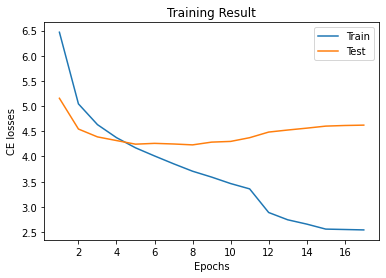

In [64]:
plt.plot([i for i in range(epoch - len(train_losses) + 1, epoch + 1)], train_losses)
plt.plot([i for i in range(epoch - len(val_losses) + 1, epoch + 1)], val_losses)
plt.xlabel('Epochs')
plt.ylabel('CE losses')
plt.title('Training Result')
plt.legend(['Train', 'Test'])
plt.show()

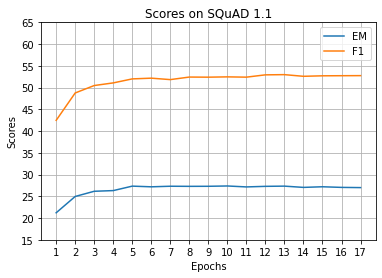

In [74]:
plt.plot([i for i in range(epoch - len(em_scores) + 1, epoch + 1)], em_scores)
plt.plot([i for i in range(epoch - len(f1_scores) + 1, epoch + 1)], f1_scores)
plt.xlabel('Epochs')
plt.ylabel('Scores')
plt.title('Scores on SQuAD 1.1')
plt.legend(['EM', 'F1'])
plt.xticks([i for i in range(1, len(f1_scores) + 1)])
plt.yticks(np.arange(15, 70, 5))
plt.savefig(f"best{epoch - len(f1_scores) + 1}-{epoch}.png", dpi=350)
plt.grid(True)
plt.show()

In [66]:
# idx = 0
# for i, t_data in enumerate(testloader):
#     idx = i
# print(idx)

In [67]:
# (p, q, s, a, p_mask, q_mask), p 길이 점점 증가
# p, q: tensor, batch size * length
# s: tuple of tensors, batch size
# a:
dataiter = iter(trainloader)
dataiter_next = dataiter.next()
dataiter_next[0].shape

torch.Size([32, 348])

In [68]:
dataiter = iter(trainloader)
for i in range(100):
    dataiter_100 = dataiter.next()
dataiter_100[1].shape

torch.Size([32, 23])

In [69]:
# start_pred.shape
# start_pred_argmax = torch.argmax(start_pred, dim=1)
# print(start_pred_argmax)
# print(span_list)
# print(span_list[0][0].item())

In [70]:
i = 0
for p, s, a in zip(paragraphs, span_list, answer_list):
    i += 1
    if i < 3:
        print(p)
        print(s)
        print(a)

NameError: name 'paragraphs' is not defined

In [ ]:
# em_score = 0
# for i, (p, s, a) in enumerate(list(zip(paragraphs, span_list, answer_list))):
#     i += 1
#     # print(i)
#     if i < 3:
#         # print(p)
#         # print(s)
#         # print(a)
#         em_score += em_func(p, a[0], s)
# print(em_score)